In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.collections import PolyCollection

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
meta = pd.read_excel('data/metadata.xlsx')
meta.sample(5)

,File name,Author,Title,Publication date,Series + n°,Editor,Illustrator,Publisher,Place of publication,Intended reader,Source intended reader,Date of debut,Author's birth date,Author's age at time of publication,Author's gender,Country,Comments,English title
40,BLACKMAN_chasingthestars_2016,Malorie Blackman,Chasing the Stars,2016,NaN,NaN,NaN,Random House Children's Publishing,London,12,website publisher,1990,1962,54,F,UK,website author: teen/ya,NaN
647,WILSON_dancingthecharleston_2019,Jacqueline Wilson,Dancing the Charleston,2019,NaN,NaN,Nick Sharratt,Doubleday,London,7,website author,1969,1945,74,F,UK,NaN,NaN
564,VANDEVENDEL_jaapdeeltklappenuit_1999,Edward van de Vendel,Jaap deelt klappen uit,1999,NaN,NaN,Jan Jutte,Querido,Amsterdam,6,website author,1996,1964,35,M,NL,NaN,NaN
671,WILSON_lolarose_2003,Jacqueline Wilson,Lola Rose,2003,NaN,NaN,Nick Sharratt,Doubleday,London,9,website author,1969,1945,58,F,UK,NaN,NaN
221,FRANCK_dewittemuur_1988,Ed Franck,De witte muur,1988,NaN,NaN,Koen Fossey,Davidsfonds,Leuven,9,CBK,1985,1941,47,M,VL,NaN,NaN


In [3]:
meta.shape

(753, 18)

In [4]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   File name                            753 non-null    object
 1   Author                               753 non-null    object
 2   Title                                753 non-null    object
 3   Publication date                     753 non-null    int64 
 4   Series  + n°                         167 non-null    object
 5   Editor                               1 non-null      object
 6   Illustrator                          410 non-null    object
 7   Publisher                            741 non-null    object
 8   Place of publication                 739 non-null    object
 9   Intended reader                      753 non-null    object
 10  Source intended reader               643 non-null    object
 11  Date of debut                        753 non-

In [5]:
memory_before = meta.memory_usage(deep=True).sum() / 1024
f'{memory_before:.2f} KB'

'596.49 KB'

## Cleaning up the dataset

(following [Matt Harrison's](https://twitter.com/__mharrison__) 'chaining' approach to Pandas)

In [6]:
meta = (
    meta
    .rename(lambda col: col.replace(' ', '_').lower(), axis=1)
    .rename(columns={'publication_date': 'pub_year', "author's_age_at_time_of_publication": 'author_age_pub', "author's_gender": 'author_gender'})
    .loc[:, ['file_name', 'author', 'title', 'pub_year', 'intended_reader', 'author_age_pub', 'author_gender', 'country']]
    .dropna(axis=0, how='any')
    .query(
        "country == 'UK' & \
        intended_reader != '-' & \
        author.str.contains('/') == False"
    )
    .astype({
        'author': 'category',
        'intended_reader': int,
        'author_gender': 'category'
    })
)

pd.to_datetime(meta['pub_year'], format='%Y')
meta.sample(10)

,file_name,author,title,pub_year,intended_reader,author_age_pub,author_gender,country
275,GAVIN_finefeatheredfriend_1996,Jamila Gavin,Fine Feathered Friend,1996,8,55,F,UK
100,CHAMBERS_thekissinggame_2011,Aidan Chambers,The Kissing Game,2011,15,77,M,UK
695,WILSON_starringtracybeaker_2006,Jacqueline Wilson,Starring Tracy Beaker,2006,9,61,F,UK
697,WILSON_thebedandbreakfaststar_1994,Jacqueline Wilson,The Bed and Breakfast Star,1994,9,49,F,UK
643,WILSON_cliffhanger_1995,Jacqueline Wilson,Cliffhanger,1995,7,50,F,UK
157,FINE_ivantheterrible_2007,Anne Fine,Ivan the Terrible,2007,9,60,F,UK
252,GAIMAN_coraline_2002,Neil Gaiman,Coraline,2002,9,42,M,UK
251,GAIMAN_anansiboys_2005,Neil Gaiman,Anansi Boys,2005,18,45,M,UK
172,FINE_savingmissmirabelle_2002,Anne Fine,Saving Miss Mirabelle,2002,9,55,F,UK
659,WILSON_hettyfeather_2009,Jacqueline Wilson,Hetty Feather,2009,9,64,F,UK


In [7]:
meta = (meta
    .assign(reader_age_group=np.where(meta['intended_reader'] == 18, 'adult' , 'child'))
    .astype({'reader_age_group': 'category'})
    .drop(['country', 'intended_reader'], axis=1)
)

In [8]:
meta.shape

(327, 7)

In [9]:
memory_after = meta.memory_usage(deep=True).sum() / 1024
print(f"{memory_after:.2f} KB")

61.35 KB


In [10]:
# memory difference
print(f"{abs(memory_after - memory_before):.2f} KB")

535.15 KB


In [11]:
meta.to_csv('data/metadata_en_baseline_sample.csv', index=False, encoding='utf-8')

### Remove authors who have published only for adults or children

In [12]:
meta.groupby('reader_age_group')['author'].value_counts(sort=False)

reader_age_group                      
adult             Aidan Chambers           0
                  Anne Fine                9
                  David Almond             2
                  Frank Cottrell-Boyce     0
                  J.K. Rowling             6
                  Jacqueline Wilson        0
                  Jamila Gavin             0
                  Jill Murphy              0
                  Malorie Blackman         0
                  Neil Gaiman              6
                  Philip Pullman           3
child             Aidan Chambers          11
                  Anne Fine               74
                  David Almond            22
                  Frank Cottrell-Boyce    13
                  J.K. Rowling             8
                  Jacqueline Wilson       69
                  Jamila Gavin            13
                  Jill Murphy             10
                  Malorie Blackman        50
                  Neil Gaiman              8
                

In the output above, we see that all authors have published books for children. We therefore need to filter out those who haven't published for adults.

In [13]:
df = (meta
    .groupby('author')
    .filter(lambda _df: _df['reader_age_group'].nunique() == 2)
)

print("Before:", meta['reader_age_group'].value_counts(sort=False), sep='\n', end='\n\n')
print("After: ", df['reader_age_group'].value_counts(sort=False), sep='\n')

Before:
adult     26
child    301
Name: reader_age_group, dtype: int64

After: 
adult     26
child    135
Name: reader_age_group, dtype: int64


In [14]:
(df
    .groupby('author', observed=True)['reader_age_group']  # `observed=True`: Hide authors with 0 observations
    .value_counts(dropna=True)
)

author               
David Almond    child    22
                adult     2
Anne Fine       child    74
                adult     9
Neil Gaiman     child     8
                adult     6
Philip Pullman  child    23
                adult     3
J.K. Rowling    child     8
                adult     6
Name: reader_age_group, dtype: int64

In [15]:
print(df.shape)

df.to_csv('data/metadata_en_final_sample.csv', index=False, encoding='utf-8')

(161, 7)


## Descriptive statistics

### Get the number of books per reader group for each of the authors

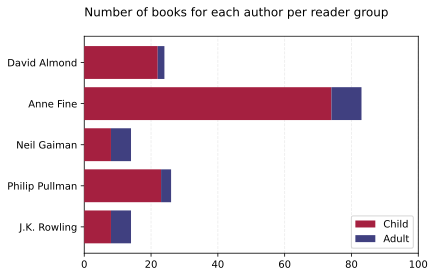

In [16]:
temp_df = df[['author', 'reader_age_group']]

ages_per_author = (
    list(
        reversed(temp_df
            .groupby('author', observed=True)['reader_age_group']
            .value_counts()
            .tolist()
        )  # reverse order to match alphabetical order below
    )
)

x = list(set(temp_df['author'].values.tolist()))
x = sorted(x, key=lambda fullname: fullname.split(' ')[-1], reverse=True) # Reverse on reverse!

y1 = np.array(
    [ages_per_author[i] 
        for i in range(1, len(ages_per_author), len(temp_df.columns))]
)

y2 = np.array(
    [ages_per_author[i] 
        for i in range(0, len(ages_per_author), len(temp_df.columns))]
)

colors = sns.color_palette('gist_stern', 7)

plt.barh(x, y1, color=colors[0], zorder=5)
plt.barh(x, y2, left=y1, color=colors[1], zorder=5)

plt.title("Number of books for each author per reader group", loc='left', pad=20)
plt.xlim(0, 100)
plt.grid(True, axis='x', alpha=.25, linestyle='--', zorder=1)
plt.legend(['Child', 'Adult'], loc='lower right');

### Authors' gender per reader group

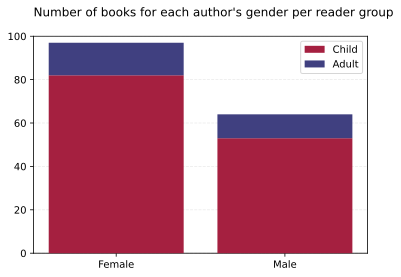

In [17]:
temp_df = df[['author_gender', 'reader_age_group']]

author_genders = (
    list(
        reversed(temp_df
            .groupby('author_gender', observed=True)['reader_age_group']
            .value_counts()
            .tolist()
        )
    )
)

x = sorted(list(set(temp_df['author_gender'].values.tolist())))

y1 = np.array(
    [author_genders[i]
        for i in range(1, len(author_genders), len(temp_df.columns))]
)

y2 = np.array(
    [author_genders[i] 
        for i in range(0, len(author_genders), len(temp_df.columns))]
)

colors = sns.color_palette('gist_stern', 7)

plt.bar(x, y1, color=colors[0], zorder=5)
plt.bar(x, y2, bottom=y1, color=colors[1], zorder=5)

plt.title("Number of books for each author's gender per reader group", loc='left', pad=20)
plt.ylim(0, 100)
plt.xticks([0, 1], labels=['Female', 'Male'])
plt.grid(True, axis='y', alpha=.25, linestyle='--', zorder=1)
plt.legend(['Child', 'Adult'], loc='upper right');

### When did each author start writing for each reader group?

In [18]:
temp_df = df[['author', 'pub_year', 'reader_age_group']]

started = (temp_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .min()
)

ended = (temp_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .max()
)

period = pd.DataFrame({'earliest_pub': started, 'latest_pub': ended})
period

earliest_pub  latest_pub
author         reader_age_group                          
David Almond   child                     1998        2021
               adult                     2011        2014
Anne Fine      child                     1978        2019
               adult                     1986        2016
Neil Gaiman    child                     1999        2013
               adult                     1996        2015
Philip Pullman child                     1982        2020
               adult                     1972        2010
J.K. Rowling   child                     1997        2020
               adult                     2012        2020

In [19]:
earliest_year = period['earliest_pub'].min()
latest_year = period['latest_pub'].max()

earliest_year, latest_year

(1972, 2021)

In [20]:
time_df = df[['author', 'pub_year', 'reader_age_group']]

years = pd.date_range(
    start=f'01/01/{earliest_year}',
    end=f'01/01/{latest_year + 1}',
    freq='Y'
)

years_list = list(years.year.values)

time_df = (
    pd.concat([
        time_df,
        pd.DataFrame(
            np.NaN,
            columns=years_list,
            index=time_df.index
        )
    ],
    axis=1)
)

time_df['Counts'] = (time_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .cumcount()
    .add(1)
)

works_df = (time_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
)

works_df

pub_year                         1972  1978  1979  1980  1981  1982  1983  \
author         reader_age_group                                             
David Almond   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Anne Fine      child                0     1     1     1     1     0     1   
               adult                0     0     0     0     0     0     0   
Neil Gaiman    child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Philip Pullman child                0     0     0     0     0     1     0   
               adult                1     1     0     0     0     0     0   
J.K. Rowling   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   

pub_year                         1985  1986  1987  ...  2012  2013  2014  \
author         reader_age_group                    ...                     
David Almond   child                0     0     0  ...     1     0     1   
               adult                0     0     0  ...     0     0     1   
Anne Fine      child                1     1     1  ...     1     5     2   
               adult                0     1     0  ...     0     0     0   
Neil Gaiman    child                0     0     0  ...     0     2     0   
               adult                0     0     0  ...     0     1     1   
Philip Pullman child                1     1     0  ...     0     0     1   
               adult                0     0     0  ...     0     0     0   
J.K. Rowling   child                0     0     0  ...     0     0     0   
               adult                0     0     0  ...     1     1     1   

pub_year                         2015  2016  2017  2018  2019  2020  2021  
author         reader_age_group                                            
David Almond   child                1     0     1     2     0     2     1  
               adult                0     0     0     0     0     0     0  
Anne Fine      child                3     0     2     1     1     0     0  
               adult                0     1     0     0     0     0     0  
Neil Gaiman    child                0     0     0     0     0     0     0  
               adult                1     0     0     0     0     0     0  
Philip Pullman child                0     0     1     0     1     1     0  
               adult                0     0     0     0     0     0     0  
J.K. Rowling   child                0     0     0     0     0     1     0  
               adult                1     0     0     1     0     1     0  

[10 rows x 43 columns]

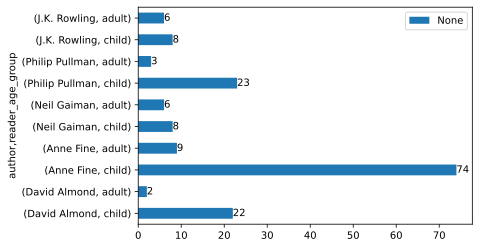

In [21]:
# Just to crosscheck with above df
ax = works_df.sum(axis=1).plot(kind='barh', legend=True)
ax.bar_label(ax.containers[0]);

In [22]:
test_df = works_df.transpose()

In [23]:
tidy_df = test_df.transpose()
tidy_df

pub_year                         1972  1978  1979  1980  1981  1982  1983  \
author         reader_age_group                                             
David Almond   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Anne Fine      child                0     1     1     1     1     0     1   
               adult                0     0     0     0     0     0     0   
Neil Gaiman    child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Philip Pullman child                0     0     0     0     0     1     0   
               adult                1     1     0     0     0     0     0   
J.K. Rowling   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   

pub_year                         1985  1986  1987  ...  2012  2013  2014  \
author         reader_age_group                    ...                     
David Almond   child                0     0     0  ...     1     0     1   
               adult                0     0     0  ...     0     0     1   
Anne Fine      child                1     1     1  ...     1     5     2   
               adult                0     1     0  ...     0     0     0   
Neil Gaiman    child                0     0     0  ...     0     2     0   
               adult                0     0     0  ...     0     1     1   
Philip Pullman child                1     1     0  ...     0     0     1   
               adult                0     0     0  ...     0     0     0   
J.K. Rowling   child                0     0     0  ...     0     0     0   
               adult                0     0     0  ...     1     1     1   

pub_year                         2015  2016  2017  2018  2019  2020  2021  
author         reader_age_group                                            
David Almond   child                1     0     1     2     0     2     1  
               adult                0     0     0     0     0     0     0  
Anne Fine      child                3     0     2     1     1     0     0  
               adult                0     1     0     0     0     0     0  
Neil Gaiman    child                0     0     0     0     0     0     0  
               adult                1     0     0     0     0     0     0  
Philip Pullman child                0     0     1     0     1     1     0  
               adult                0     0     0     0     0     0     0  
J.K. Rowling   child                0     0     0     0     0     1     0  
               adult                1     0     0     1     0     1     0  

[10 rows x 43 columns]

In [24]:
tidy_df = (
    pd.melt(
        works_df.reset_index(),
        id_vars=('author', 'reader_age_group'),
        var_name='pub_year',
        value_name='count'
    )
)

print("Before:", tidy_df.shape)

tidy_df = (
    tidy_df[tidy_df['count'] > 0]
    .astype({'count': int})
)

print("After:", tidy_df.shape)

tidy_df['pub_year'] = pd.to_datetime(tidy_df['pub_year'], format='%Y').dt.year
tidy_df

Before: (430, 4)
After: (113, 4)


,author,reader_age_group,pub_year,count
7,Philip Pullman,adult,1972,1
12,Anne Fine,child,1978,1
17,Philip Pullman,adult,1978,1
22,Anne Fine,child,1979,1
32,Anne Fine,child,1980,1
...,...,...,...,...
410,David Almond,child,2020,2
416,Philip Pullman,child,2020,1
418,J.K. Rowling,child,2020,1
419,J.K. Rowling,adult,2020,1


In [25]:
simple_df = tidy_df.copy()

simple_df['pub_year_start'] = (
    pd.to_datetime(
        simple_df['pub_year'],
        format='%Y'
    )
    .dt.strftime('%Y-%m-%d')
)

simple_df['pub_year_end'] = (
    pd.to_datetime(simple_df['pub_year_start'], format='%Y-%m-%d')
    + pd.DateOffset(months=11, days=30)
)
simple_df.head()

,author,reader_age_group,pub_year,count,pub_year_start,pub_year_end
7,Philip Pullman,adult,1972,1,1972-01-01,1972-12-31
12,Anne Fine,child,1978,1,1978-01-01,1978-12-31
17,Philip Pullman,adult,1978,1,1978-01-01,1978-12-31
22,Anne Fine,child,1979,1,1979-01-01,1979-12-31
32,Anne Fine,child,1980,1,1980-01-01,1980-12-31


In [26]:
authors = [author for author in simple_df['author'].unique()]

author_1_df = simple_df[simple_df['author'] == authors[0]]
author_2_df = simple_df[simple_df['author'] == authors[1]]
author_3_df = simple_df[simple_df['author'] == authors[2]]
author_4_df = simple_df[simple_df['author'] == authors[3]]
author_5_df = simple_df[simple_df['author'] == authors[4]]

# Constants
CATEGORIES = {
    "child": 1,
    "adult": 2
}

CMAPS = {
    "child": "#a52040",
    "adult": "#404080"
}

START_YEAR = mdates.datestr2num(str(min(years_list) - 2))
END_YEAR = mdates.datestr2num(str(max(years_list) + 2))
TITLE_PAD = 16
Y_LABELS = ["Child", "Adult"]

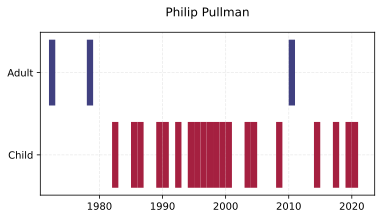

In [27]:
author_1 = author_1_df['author'].unique()[0]
data_1 = (author_1_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_1.keys()):
    if data_1[k] == 0:
        del data_1[k]

verts = []
colors = []

for d in data_1:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_1, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

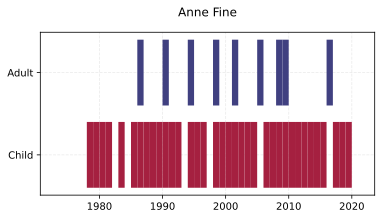

In [28]:
author_2 = author_2_df['author'].unique()[0]
data_2 = (author_2_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_2.keys()):
    if data_2[k] == 0:
        del data_2[k]

verts = []
colors = []

for d in data_2:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_2, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

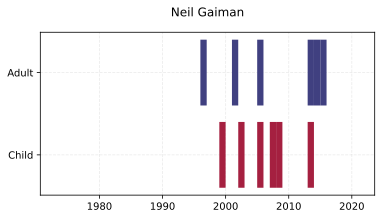

In [29]:
author_3 = author_3_df['author'].unique()[0]
data_3 = (author_3_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_3.keys()):
    if data_3[k] == 0:
        del data_3[k]

verts = []
colors = []

for d in data_3:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_3, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

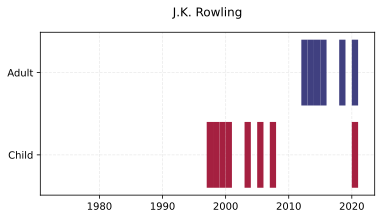

In [30]:
author_4 = author_4_df['author'].unique()[0]
data_4 = (author_4_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_4.keys()):
    if data_4[k] == 0:
        del data_4[k]

verts = []
colors = []

for d in data_4:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_4, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

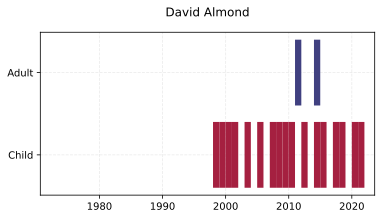

In [31]:
author_5 = author_5_df['author'].unique()[0]
data_5 = (author_5_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_5.keys()):
    if data_5[k] == 0:
        del data_5[k]

verts = []
colors = []

for d in data_5:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_5, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()